In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import os
from itertools import product

from tools_fixed import PatchForager

In [2]:
# Parameters of reward in each patch for fixed rew
travel_time = 3
reward_value = [5, 5, 5]
num_rew = [1,3,0]
first_rew = [0,2,0]
last_rew = [num_rew[0],num_rew[1],0] #this needs to be a fxn of rew or stops, careful setting values
reward_prob = [.9,.9,0]

# Example usage
type_patches = len(num_rew)
num_patches = 10

#Three alternative ways to generate a list of patches
patch_list = list(range(type_patches)) #equal distribution of patches
patch_list = [random.randint(0, type_patches-1) for _ in range(num_patches)] #randomly generated list of patched
# patch_list = data # import data from session {To Be Implemented..}

# Create the reward prob matrix
a = np.zeros((type_patches, max(last_rew)+1), dtype=float)
b = np.zeros((type_patches, 1), dtype=float)
c = np.zeros((type_patches, 1), dtype=float)

# Set depletion curves
for patch_id in range(type_patches):
    a[patch_id, :num_rew[patch_id]] = reward_prob[patch_id] # fixed prob for each patch TODO make more flexible
    b[patch_id] = first_rew[patch_id]
    c[patch_id] = last_rew[patch_id]
    
d = '_'

forager = PatchForager(travel_time, reward_value, a, b, c, d, prob=True, depl_fxn = 'fixed')
mvt_optimal = forager.calculate_optimal_stops(patch_list)

In [16]:
# Create a directory for the simulation results
import h5py
os.makedirs('data', exist_ok=True)

type_patches = 2
num_patches = 200
patch_list = [random.randint(0, type_patches-1) for _ in range(num_patches)] #randomly generated list of patched

forager = PatchForager(travel_time, reward_value, a, b, c, d, prob=True)

# Define the strategies and their parameters
strategy_struct = {
    'rewards': {'strategy': 'rewards', 'params': {'target_rewards': [1,3]}}, #this seems to run forever sometimes, maybe never leaves?
    'stops': {'strategy': 'stops', 'params': {'target_stops': [1,5]}},
    'rate': {'strategy': 'rate', 'params': {'target_reward_rate': 1}},#mvt_optimal['max_reward_rate']}},
    'failures': {'strategy': 'failures', 'params': {'max_failures': 1}},
    'consec_failures': {'strategy': 'consec_failures', 'params': {'consec_failures': 2}}
}

# Create an HDF5 file
with h5py.File('data/data.h5', 'w') as hf:
    for i in range(20):
        # Create a group for this simulation
        sim_group = hf.create_group(f'simulation_{i}')
        
        # Run the simulation for each strategy
        for strategy_name, strategy_info in strategy_struct.items():
            data, _ = forager.run_simulation(strategy_info['strategy'], patch_list, **strategy_info['params'])
            
            # Save results
            data = data.replace({None: np.nan})
            dataset = sim_group.create_dataset(strategy_name, data=data.to_numpy())
            # Save column names as attributes
            dataset.attrs['columns'] = data.columns.tolist()

/var/folders/rv/bpj1qnwx5lz32q8rr9jxs07h0000gp/T/ipykernel_9682/792652471.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({None: np.nan})


In [17]:
print(mvt_optimal['max_reward_rate'],mvt_optimal['optimal_stops'])

1.4035087719298245 (2, 5, 0)


In [18]:
# Function to read data from HDF5 file
def read_h5_data(file_path, simulation_number, strategy):
    with h5py.File(file_path, 'r') as hf:
        dataset = hf[f'simulation_{simulation_number}/{strategy}']
        return pd.DataFrame(dataset[:], columns=dataset.attrs['columns'])

# Set up the plotting style
plt.style.use('ggplot')

# File path
h5_file_path = 'data/data.h5'

# Get a list of distinct colors from matplotlib colormap
colors = plt.get_cmap('tab10')  # You can change 'tab10' to other colormaps if needed

# Create the color_set dictionary
color_set = {strategy: colors(i) for i, strategy in enumerate(strategy_struct.keys())}

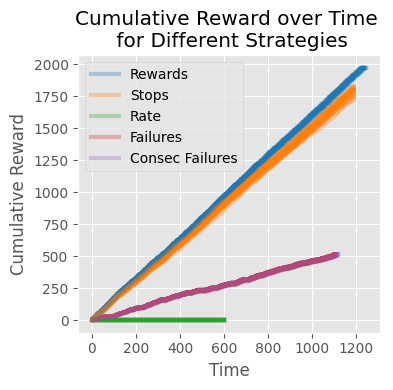

In [19]:
plt.figure(figsize=(4, 4))
for sim_num in range(20):  # Assuming 20 simulations

    for strategy in strategy_struct.keys():
        # Read data for this simulation and strategy
        data = read_h5_data(h5_file_path, sim_num, strategy)
        
        # Plot cumulative reward over time
        plt.plot(data['time'], data['reward'].cumsum(), label=strategy.replace('_', ' ').title(),alpha = .3,
                 lw = 3,color = color_set[strategy])

    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Cumulative Reward over Time \n for Different Strategies')
    
    if sim_num==0:
        plt.legend()
        
    plt.grid(True)
    plt.tight_layout()
    
    # Save the plot
plt.savefig(f'figs/cumulative_reward_all.png', bbox_inches='tight', dpi=300)
# plt.close()  # Close the figure to free up memory

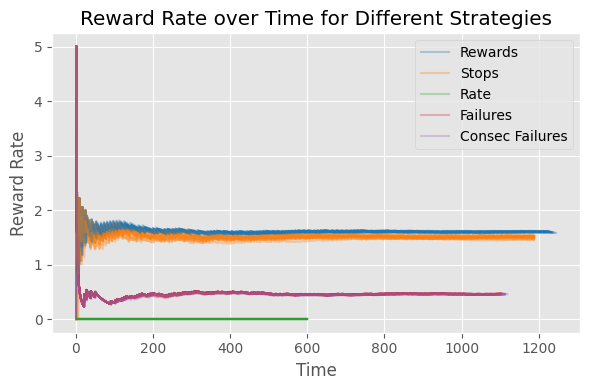

In [20]:
# Number of simulations
num_simulations = 20

# Plot: Reward Rate over Time
plt.figure(figsize=(6, 4))
for sim_num in range(num_simulations):
    for strategy in strategy_struct.keys():
        # Read data for this simulation and strategy
        data = read_h5_data(h5_file_path, sim_num, strategy)
        
        # Calculate reward rate
        cumulative_reward = data['reward'].cumsum()
        reward_rate = cumulative_reward / data['time']
        
        # Plot reward rate over time
        plt.plot(data['time'], reward_rate, label=strategy.replace('_', ' ').title() if sim_num == 0 else "", 
                 alpha=0.3, color=color_set[strategy])
    if sim_num == 0:
        plt.legend()

plt.xlabel('Time')
plt.ylabel('Reward Rate')
plt.title('Reward Rate over Time for Different Strategies')

plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('figs/reward_rate_all.png', bbox_inches='tight', dpi=300)